In this notebook, we carry out the research of a burn-mapping method.

In [1]:
from plot_tools import plot
import matplotlib.pyplot as plt

**TEST**

In [2]:
import sampling
import gui

import importlib

importlib.reload(sampling)
importlib.reload(gui)

from sampling import *
from gui import GUI

**Change product**

In [3]:
img_f = 'test_C11659/small2/1009.bin'
polygon_f = 'test_C11659/small2/polygon_0000.bin'

In [4]:
g = GUI(
    polygon_filename=polygon_f,
    image_filename=img_f
)

In [5]:
#Choice of band
g.embed_band_list = [1,2,4,5,6,8,9,10,12,13]
g.img_band_list = [9, 10, 13]

#Get data from choice
image_title, image = g.get_shown_image()

IMAGE = g.get_band_image()

embed_title, embed = g.get_band_embed()

RUNNING ... band_list = [1, 2, 4, 5, 6, 8, 9, 10, 12, 13] @ pid = 2036627.
DONE! ... band_list = [1, 2, 4, 5, 6, 8, 9, 10, 12, 13] @ pid = 2036627.


**For the labels**, from index 0 to in_sample_size is all 0 (inside) and the rest is 1

In [6]:
import numpy as np

In [7]:
labels = np.ones(g.sample_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/lib/python3/dist-packages/matplotlib/cm.py:496: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


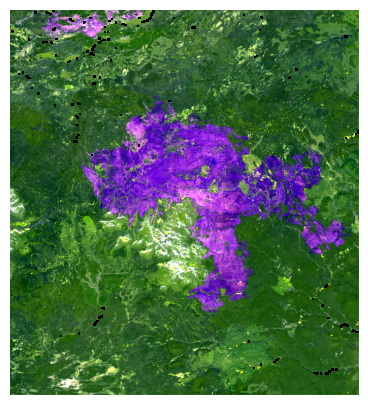

In [8]:
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

**Classify the rest of the image**

The tsne we are seeing is just the sample, a very tiny part of it. Since we randomly sampled, it could be a pretty good representative of the big picture.

Datasets

In [9]:
X = g.samples[..., [b-1 for b in g.embed_band_list]] #Get only the band we need
y1 = embed[:, 0]
y2 = embed[:, 1]

In [10]:
from cuml.neighbors import KNeighborsRegressor

In [11]:
knn_tsne1 = KNeighborsRegressor(
    n_neighbors=1,
    weights="uniform", # important
    algorithm="brute",
    metric="minkowski", # Euclidean
    p=2
)

In [12]:
knn_tsne1.fit(X, y1)

KNeighborsRegressor()

In [13]:
knn_tsne2 = KNeighborsRegressor(
    n_neighbors=1,
    weights="uniform", # important
    algorithm="brute",
    metric="minkowski", # Euclidean
    p=2
)

In [14]:
knn_tsne2.fit(X, y2)

KNeighborsRegressor()

**Input image (all image)**

In [15]:
n_bands = len(g.embed_band_list)

input_img = IMAGE.reshape(-1, n_bands)

input_img = np.nan_to_num(input_img, nan=0.0)

**Approximate TSNE embedding for all Input image**

In [16]:
tsne1 = knn_tsne1.predict(input_img)
tsne2 = knn_tsne2.predict(input_img)

As per the classifier, the portion to the right will be classfied as "in the perimeter"

In [17]:
X_tsne = np.column_stack((tsne1, tsne2))

**HDBSCAN**

What if we dont know where the fire was? We just got an image and we need to know the mapping. AKA no labels given.

This algorithm can help.

In [18]:
from cuml.cluster.hdbscan import HDBSCAN
from cuml.cluster.hdbscan import approximate_predict

In [19]:
scan = HDBSCAN(
    min_cluster_size=1000, # start here
    min_samples=10, # controls conservativeness
    metric='euclidean'
)

pred = scan.fit_predict(embed)

scan.generate_prediction_data()

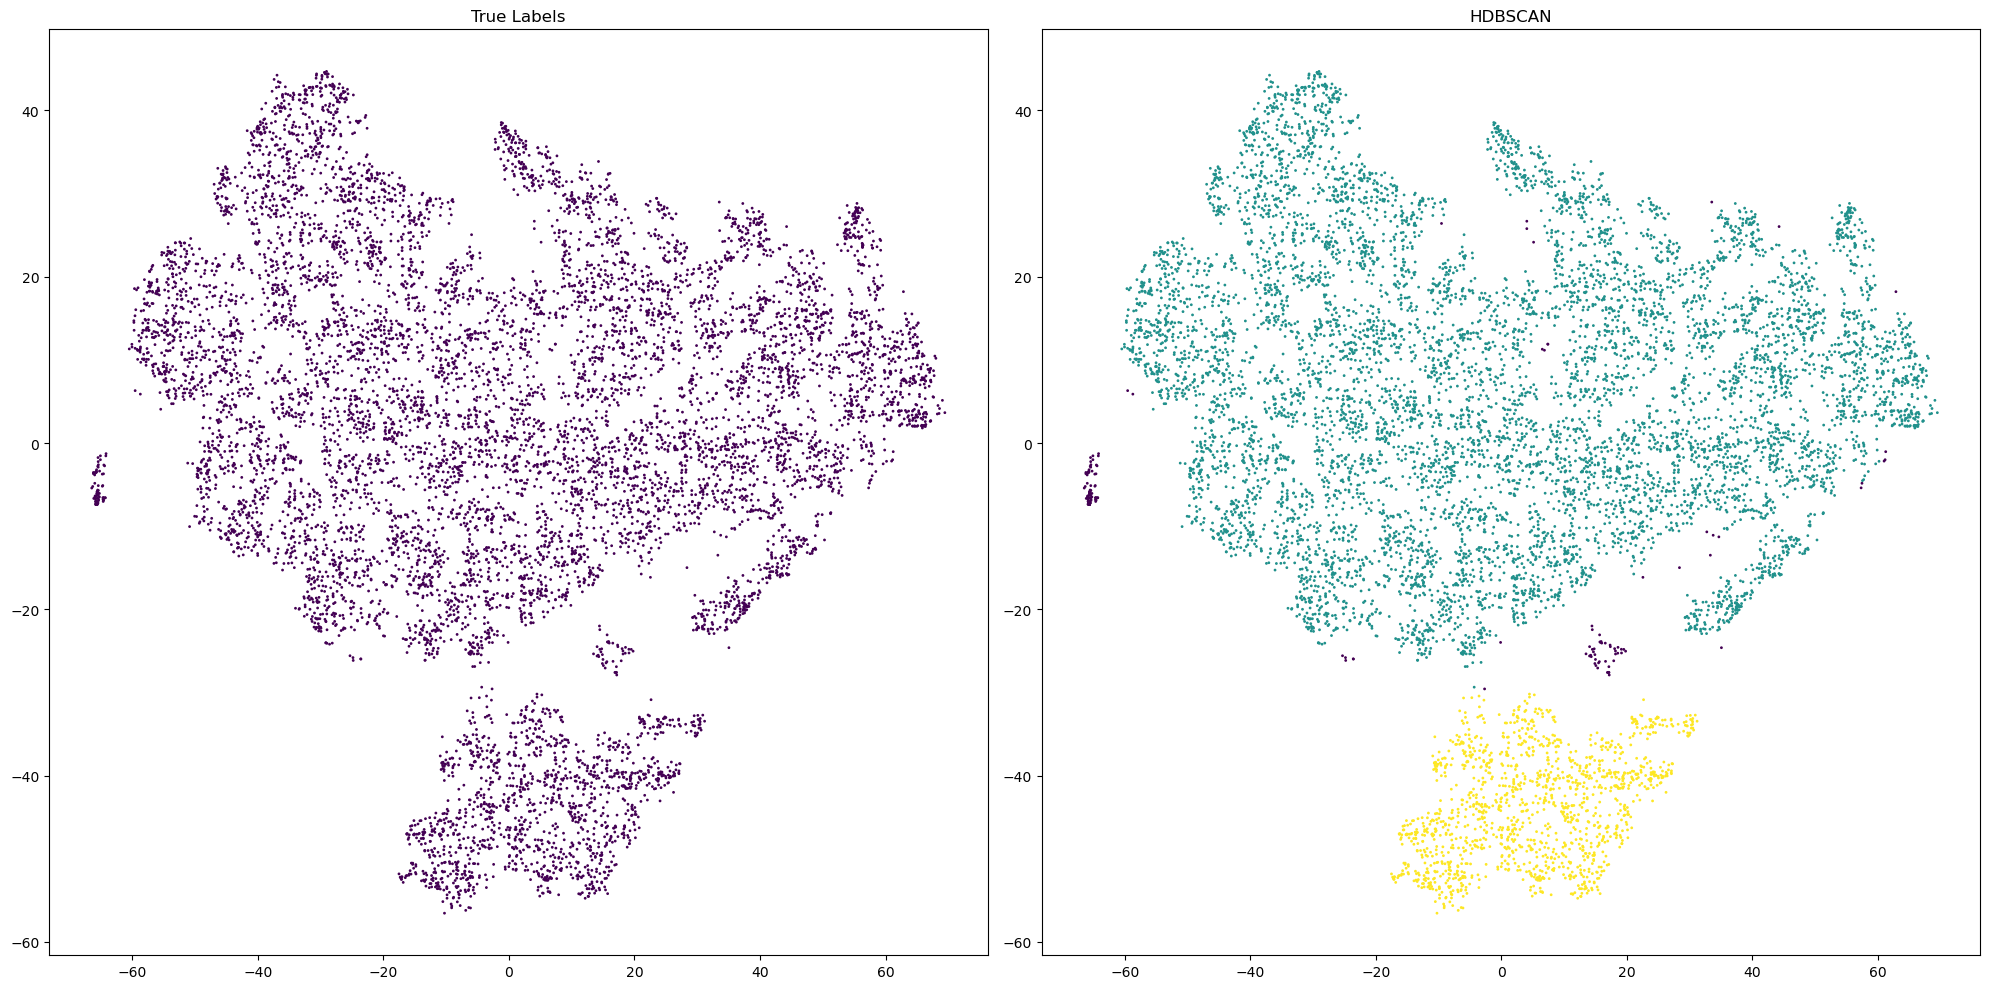

In [20]:
fig, ax_tsne = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 10))

ax_tsne[0].scatter(
    embed[:, 0], 
    embed[:, 1], 
    c = labels,
    s = 1
)
ax_tsne[0].set_title('True Labels')


ax_tsne[1].scatter(
    embed[:, 0], 
    embed[:, 1], 
    c = pred,
    s = 1
)
ax_tsne[1].set_title('HDBSCAN')

plt.tight_layout()

plt.show()

**Prediction**

In [21]:
new_labels, strengths = approximate_predict(scan, X_tsne)

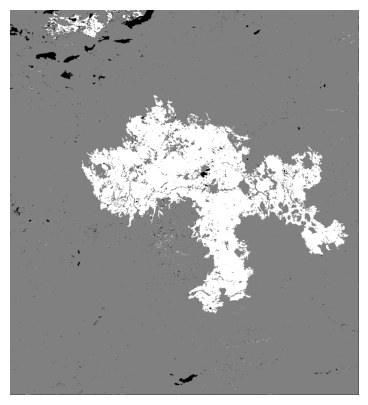

In [22]:
plt.figure(figsize=(5,5))
plt.imshow(new_labels.reshape(g.image._ySize, g.image._xSize), cmap='gray')
plt.axis('off')
plt.show()

**SAME IMPLEMENTATION BUT FROM GUI**

In [23]:
img_cluster = g.map_burn()

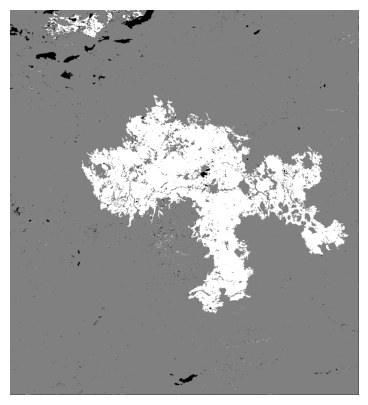

In [24]:
plt.figure(figsize=(5,5))
plt.imshow(img_cluster.reshape(g.image._ySize, g.image._xSize), cmap='gray')
plt.axis('off')
plt.show()